
# load_confounds

This notebook show how to extract signals from a brain parcellation and compute a correlation matrix, using different denoising strategies using the [load_confounds](https://github.com/simexp/load_confounds) package. This notebook is adapted from a [nilearn tutorial](https://nilearn.github.io/auto_examples/03_connectivity/plot_signal_extraction.html#sphx-glr-auto-examples-03-connectivity-plot-signal-extraction-py). 

## Retrieve the atlas and the data

To demonstrate of denoising works with resting-state connectivity, we first need to retrieve an fMRI dataset preprocessed with fMRIprep, as well as brain regions (here the Harvard-Oxford atlas).

In [1]:
from nilearn import datasets

dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset.maps
labels = dataset.labels

print('Atlas ROIs are located in nifti image (4D) at: %s' %
      atlas_filename)  # 4D data

# One subject of brain development fmri data
data = datasets.fetch_development_fmri(n_subjects=1, reduce_confounds=False)
fmri_filenames = data.func[0]

Atlas ROIs are located in nifti image (4D) at: /home/pbellec/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz


/home/pbellec/env/load_confounds/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Load confounds with the Params9 strategy

fMRIprep saves confounds into a pair of tsv/json files that live next to the preprocessed fMRI data. When given the path to the fMRI filename, the predefined strategies in `load_confounds` will auto-detect the companion tsv and json files as long as they reside in the same directory. For this example we will choose the `Params9` strategy. 

In [2]:
from load_confounds import Params9
confounds = Params9().load(fmri_filenames)
print("The shape of the confounds matrix is:", confounds.shape)

The shape of the confounds matrix is: (168, 13)


# Extract activity in brain regions

[nilearn](https://nilearn.github.io/) offers a series of tools to load fMRI data using python. These tools are called [maskers](https://nilearn.github.io/manipulating_images/masker_objects.html). Here we are using a masker that extracts the average time series within each ROI of the Harvard-Oxford atlas. We simply feed the `confounds` array into the corresponding argument of the masker.  

In [3]:
from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,
                           memory='nilearn_cache', verbose=5)

# From nifti files to a numpy array.
time_series = masker.fit_transform(fmri_filenames, confounds=confounds)

[NiftiLabelsMasker.fit_transform] loading data from /home/pbellec/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz
Resampling labels
[Memory]0.0s, 0.0min    : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


# Compute and display a functional connectome

Note the square diagonals in the connectomes, reflecting the presence of functional networks.

/home/pbellec/env/load_confounds/lib/python3.8/site-packages/nilearn/plotting/matrix_plotting.py:22: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  ylabel_width = ax.yaxis.get_tightbbox(renderer).inverse_transformed(
/home/pbellec/env/load_confounds/lib/python3.8/site-packages/nilearn/plotting/matrix_plotting.py:30: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  xlabel_height = ax.xaxis.get_tightbbox(renderer).inverse_transformed(


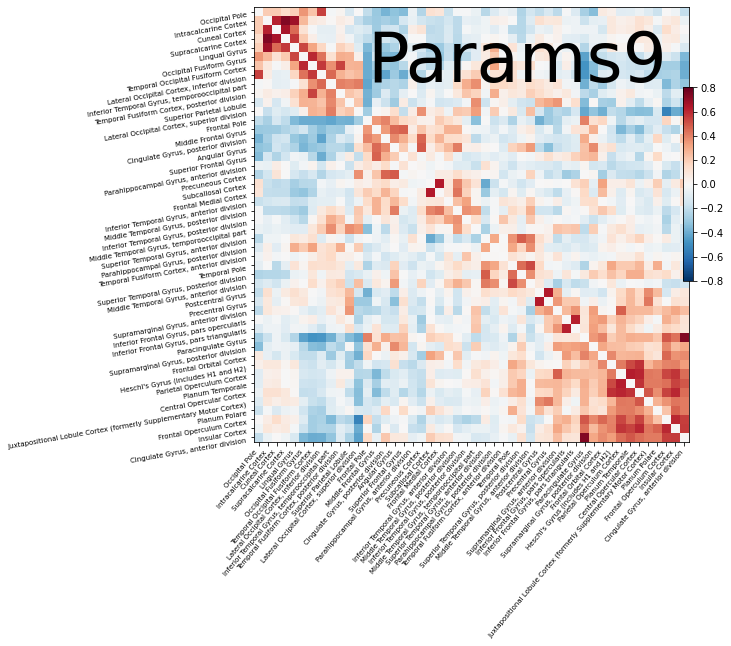

In [4]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Plot the correlation matrix
import numpy as np
from nilearn import plotting
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels[1:],
                     vmax=0.8, vmin=-0.8, title='Params9', reorder=True)

## Load confounds from file using a flexible strategy

Alternatively, `load_confounds` can be used to create a `Confounds` class with flexible parameters. We create a `Confounds` class which specifies strategies and optional parameters. Then the `load()` method selects the relevant columns from the TSV file. Let's try a strategy similar to `Params9`, but without the global signal regression:

In [5]:
from load_confounds import Confounds
conf = Confounds(strategy=["high_pass", "motion", "wm_csf"], 
                 motion="basic", wm_csf="basic")

confounds_flexible = conf.load(fmri_filenames)

print("The shape of the confounds matrix is:", confounds_flexible.shape)
time_series_flexible = masker.fit_transform(fmri_filenames, confounds=confounds_flexible)

The shape of the confounds matrix is: (168, 12)
[NiftiLabelsMasker.fit_transform] loading data from /home/pbellec/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz
[Memory]1.5s, 0.0min    : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


/home/pbellec/env/load_confounds/lib/python3.8/site-packages/nilearn/plotting/matrix_plotting.py:22: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  ylabel_width = ax.yaxis.get_tightbbox(renderer).inverse_transformed(
/home/pbellec/env/load_confounds/lib/python3.8/site-packages/nilearn/plotting/matrix_plotting.py:30: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  xlabel_height = ax.xaxis.get_tightbbox(renderer).inverse_transformed(


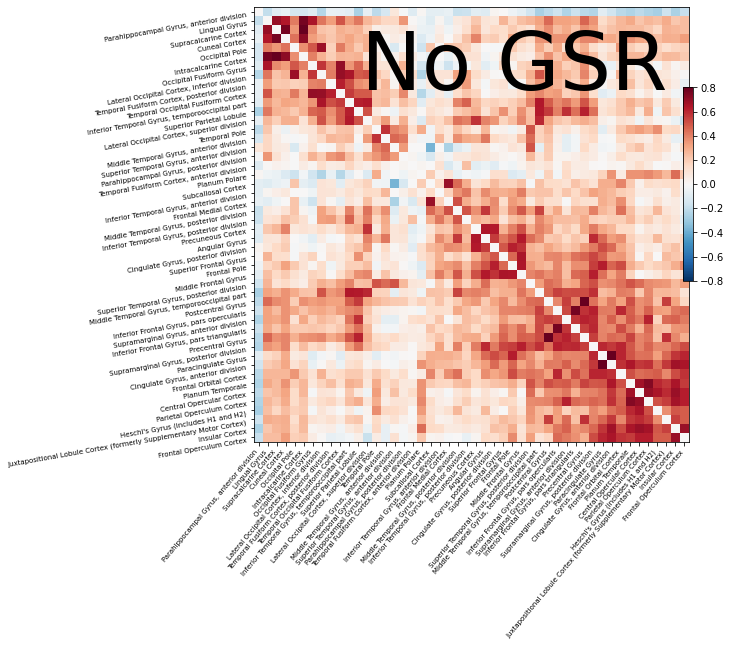

In [6]:
correlation_matrix = correlation_measure.fit_transform([time_series_flexible])[0]

# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)

plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels[1:],
                     vmax=0.8, vmin=-0.8, title='No GSR', reorder=True)

plotting.show()

We can see that without GSR there are very few negative correlations, and that the connectivity values overall changed dramatically because of this choice of denoising strategy.